### This is code is written for the project 2 of the Self Driving Car Course, and parts of the code are taken from it the course

In [1]:
# Libraries
import tensorflow as tf
import pickle
from sklearn.cross_validation import train_test_split
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten

## Step 0: Load the Data

### Importing the data, saved from pickling and then changing the protocol of a file in python3(see .py file attached in the submission)


In [2]:
# Reading the data
training_file = 'train1.pkl'
testing_file = 'test1.pkl'
with open(training_file, mode = 'rb') as f:
    train = pickle.load(f)
with open(testing_file, mode = 'rb') as f:
    test = pickle.load(f)

## Step 1: Dataset Summary & Exploration
The pickled data is a dictionary with 4 key/value pairs:

* 'features' is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
* 'labels' is a 1D array containing the label/class id of the traffic sign. The file signnames.csv contains id -> name mappings for each id.
* 'sizes' is a list containing tuples, (width, height) representing the the original width and height the image.
* 'coords' is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
# Number of training examples
n_train = len(train['features'])

# Number of testing examples.
n_test = len(test['features'])

# What's the shape of an traffic sign image?
image_shape = train['features'][0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(set(train['labels']))

print("Number of training examples = {}" .format(n_train))
print("Number of testing examples = {}" .format(n_test))
print("Image data shape = {}" .format(image_shape))
print("Number of classes = {}" .format(n_classes))

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


## Step 2: Design and Test a Model Architecture

### Implementation

#### Question 1:
Describe how you preprocessed the data. Why did you choose that technique?

#### Answer 1:
The training set is first split is 70:30 for training and validation, this is done to create a validation dataset to test the model without contaminating the test set provided.
Also, Normalization technique is utilized over each pixel (i.e. (R/G/B -128)/128), this is done to reduce the range of pixel values, initially the range was 0-255 now the range is -1 to 1. As weights are initialized randomly, therefore, updating it will take a lot of time if input values are spread across a higher range, but normalizing, we are not only able to save on the speeding up the process to find global optima, and reduces the chances to getting stuck in a local optima, while still saving the relative closeness among the inputs.

#### Question 2:
Describe how you set up the training, validation and testing data for your model. Optional: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?

#### Answer 2:
I split the training data in 70:30 to create a training and validation dataset. Although, I did not generate more data, but in case, if I want to I can 

* duplicate existing values
* use various techniques like SMOTE to create random data
* Rotate the existing images in the dataset to create new images

### Creating a Training, Testing set

In [4]:
X_train1, y_train1 = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

### Normalizing the Training images

In [5]:
X_train1 = X_train1.astype('float32')
for num in range(n_train):
    for x in xrange(0,32):
        for y in xrange(0,32):
            [r,g,b] = X_train1[num][x,y]
        
            r = (r-128)/128.0
            g = (g-128)/128.0
            b = (b-128)/128.0
            X_train1[num][x,y] = [r,g,b]

### Normalizing the Testing images

In [6]:
X_test = X_test.astype("float32")
for num in range(n_test):
    for x in xrange(0,32):
        for y in xrange(0,32):
            [r,g,b] = X_test[num][x,y]
        
            r = (r-128)/128.0
            g = (g-128)/128.0
            b = (b-128)/128.0
            X_test[num][x,y] = [r,g,b]

### Creating a validation set from Training

In [7]:
# Shuffling the training set
X_train1, y_train1 = shuffle(X_train1, y_train1)

In [8]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train1, y_train1, test_size = 0.3)

#### As the images are already in 32x32 size therefore there is no need of providing extra padding

### Visualizing the image

Visualizing multiple images after normalization

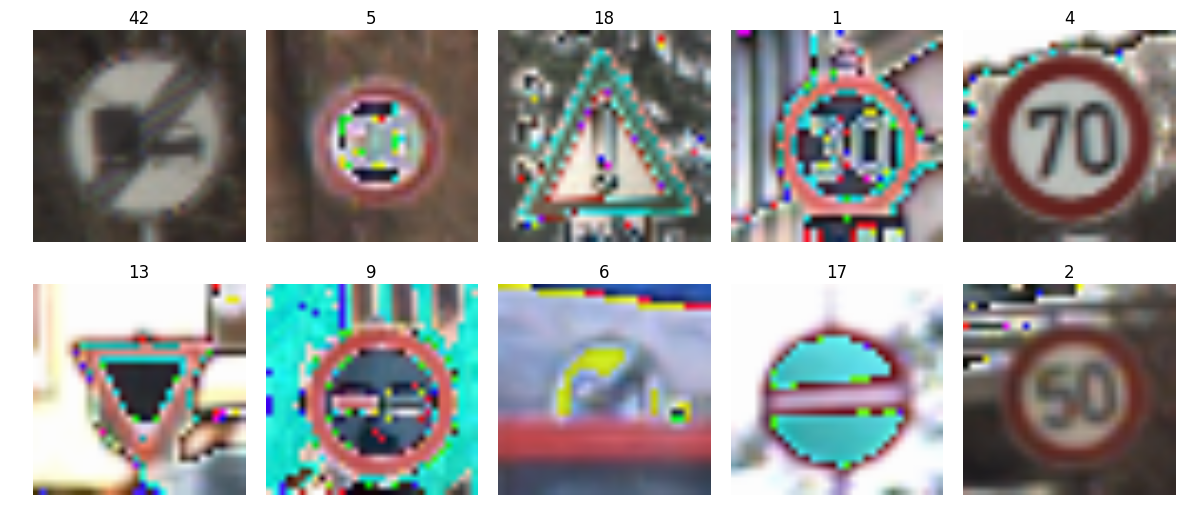

In [9]:
# show image of 10 random data points
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(10):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_train[index])

### Reading the sign names csv file

In [10]:
signnames = pd.read_csv("signnames.csv")
signnames.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


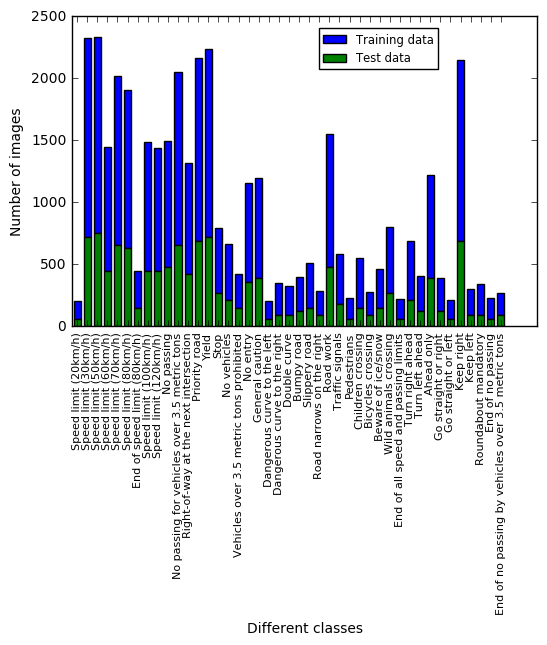

In [11]:
# histogram of label frequency
hist, bins = np.histogram(y_train, bins=n_classes)
hist_2, bins_2 = np.histogram(y_test, bins=n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

p1 = plt.bar(center, hist, align='center', width=width, bottom=hist_2, color='b')
p2 = plt.bar(center, hist_2, align='center', width=width, color='g')
plt.ylabel('Number of images')
plt.xlabel('Different classes')
plt.xticks(center, signnames.SignName, rotation = 'vertical', fontsize=8)
plt.legend((p1[0], p2[0]), ('Training data', 'Test data'), fontsize = 'small', loc='upper right', bbox_to_anchor=(.8, .98))
plt.show()

#### Question 3:
What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.) For reference on how to build a deep neural network using TensorFlow, see Deep Neural Network in TensorFlow from the classroom.

### Setting up the Tensorflow 

In [12]:
epoch = 38                        # how many time to run the training data to run through the network
Batch_size = 128

### Neural Net Architecture

In [13]:
def NeuArch(X_input_, keep_prob):
    # arguments to initialize the weights
    mu = 0
    sigma = 0.1
    
    # 1st Layer; (Convolutional)
    conv1_W = tf.Variable(tf.truncated_normal((5,5,3,10), mean= mu, stddev= sigma))
    conv1_b = tf.Variable(tf.zeros(10))
    
    conv1 = tf.nn.conv2d(X_input_, conv1_W, strides=[1,1,1,1], padding='VALID') + conv1_b  # 28
    # Activation funcion
    conv1 = tf.nn.relu(conv1)
    # Pooling layer
    pool1 = tf.nn.max_pool(conv1, ksize= [1,2,2,1], strides=[1,2,2,1], padding='VALID')   # 14
    # ----------------------------------------------------------------------------------------
    
    # 2nd Layer, (Convolution)
    conv2_W = tf.Variable(tf.truncated_normal((3,3,10,26), mean = mu, stddev=sigma))
    conv2_b = tf.Variable(tf.zeros(26))
    
    conv2 = tf.nn.conv2d(pool1, conv2_W, strides=[1,1,1,1], padding='VALID') + conv2_b  # 12
    # Activation Layer
    conv2 = tf.nn.relu(conv2)
    # Pooling Layer
    pool2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')  # 6
    # -----------------------------------------------------------------------------------------
       
    # 3rd Layer; (fully connected layer)
    # first flattening the pixels in a image
    fc0 = flatten(pool2)
    
    fc1_W = tf.Variable(tf.truncated_normal((936, 300), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(300))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    
    # activation
    fc1 = tf.nn.relu(fc1)
    # dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)
    # ------------------------------------------------------------------------------------------
    
    # 4th Layer; (fully connection layer)
    fc2_W = tf.Variable(tf.truncated_normal((300,114), mean= mu, stddev= sigma))
    fc2_b = tf.Variable(tf.zeros(114))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
    
    # activation
    fc2 = tf.nn.relu(fc2)
    # dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)
    # -------------------------------------------------------------------------------------------
    
    # Final Output Layer
    fc3_W = tf.Variable(tf.truncated_normal((114,43), mean=mu, stddev=sigma))
    fc3_b = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2,fc3_W) + fc3_b
    
    return logits
    

### Features and Labels

In [14]:
x_ = tf.placeholder(tf.float32, (None,32,32,3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32)

#### Question 4:
How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)

#### Answer 4:
Below are some hyperparameter set for training the model
* **Batch Size** = 128; Standard, batch size gives the ability to train a subset of the data rather than the whole data together, if the computer lacks the space. While 128 is considered a standard batch size, after trail and error it also provides the optimal balance between space and speed of the model.
* **Epoch** =  38; It is a single backward and forward pass of the neural net, the more the number of epoch the better the accuracy, but more the running time of the model. As, the current architecture in ran on a CPU therefore, 38 epoch gives the perfect balance between runnning time and accuracy.
* **Learning rate(rate)** =  0.0015; Learning rate decides how much the weights should be adjusted wrt delta function. Although, it is more of a trial and error testing, but with higher learning rate, the model learns faster, but there is an possibility of overshooting the global optima, and then the model would just revolve around the global optima and a lower learning rate, will take a lot more number of runs to each the global optima. I choose 0.0015, as neither overshoots the global optima, nor is slow in reaching it.
* **Dropout(keep probability)** = 0.75, Dropout is the % of neurons removed for consideration on the next layer, it is a form of regularization technique with the aim to reduce overfitting, but if you remove too many neurons, it could lead to lower accuracy, as it might reduce the features learnt in each layer.
* **Optimizer** = AdamOptimizer; Foremost is that it uses moving averages of the parameters (momentum), which can give faster convergence.This enables the optimizer to use a larger step size, and the algorithm will converge to this step size. Also, Adamoptimizer adaptively select a separate learning rate for each parameter. Parameters that would ordinarily receive smaller or less frequent updates receive larger updates(and vice versa). This speeds learning in cases where the appropriate learning rates vary across parameters. 

### Training Pipeline

In [15]:
rate = 0.0015
logits = NeuArch(x_, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)

### Model Evaluation

In [16]:
correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(one_hot_y,1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, Batch_size):
        batch_x, batch_y = X_data[offset:offset+Batch_size], y_data[offset:offset+Batch_size]
        accuracy = sess.run(accuracy_operation, feed_dict={x_: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Training the Tensorflow Model

In [17]:
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
#    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(epoch):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, Batch_size):
            end = offset + Batch_size
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x_: batch_x, y: batch_y, keep_prob: 0.75})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'project2_')
    print("Model saved")

Training...
()
EPOCH 1 ...
Validation Accuracy = 0.865
()
EPOCH 2 ...
Validation Accuracy = 0.952
()
EPOCH 3 ...
Validation Accuracy = 0.970
()
EPOCH 4 ...
Validation Accuracy = 0.981
()
EPOCH 5 ...
Validation Accuracy = 0.980
()
EPOCH 6 ...
Validation Accuracy = 0.984
()
EPOCH 7 ...
Validation Accuracy = 0.985
()
EPOCH 8 ...
Validation Accuracy = 0.989
()
EPOCH 9 ...
Validation Accuracy = 0.989
()
EPOCH 10 ...
Validation Accuracy = 0.988
()
EPOCH 11 ...
Validation Accuracy = 0.988
()
EPOCH 12 ...
Validation Accuracy = 0.992
()
EPOCH 13 ...
Validation Accuracy = 0.988
()
EPOCH 14 ...
Validation Accuracy = 0.988
()
EPOCH 15 ...
Validation Accuracy = 0.989
()
EPOCH 16 ...
Validation Accuracy = 0.989
()
EPOCH 17 ...
Validation Accuracy = 0.992
()
EPOCH 18 ...
Validation Accuracy = 0.991
()
EPOCH 19 ...
Validation Accuracy = 0.992
()
EPOCH 20 ...
Validation Accuracy = 0.992
()
EPOCH 21 ...
Validation Accuracy = 0.989
()
EPOCH 22 ...
Validation Accuracy = 0.990
()
EPOCH 23 ...
Validation Ac

#### Question 5:
What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem.

#### Answer 5:
The various steps taken to reach the final model are:
1. Started with the Lenet Architecture, as it consist of a mixture of convolution and fully connected layers, which was suitable for the current problem as it a provides good classification accuracy and also its not a pretty complex implementation either.
2. As the accuracy was .95+, therefore, I introduced dropouts to avoid overfitting, with a keep_prob of .80, I increased the epoch to 15 from 10, as higher epoch could lead to better accuracy.
3. With a litte increase in accuracy, Then I wanted to capture more pixel information, to improve the model, I changed the filter to 3x3 from 5x5 and also, the dimension of the fully connected layer was changed to 220 and 114.
4. With success of previous step, the dimension of fully connected layer were then changed to 300 and 114, to be able to capture more information from the convolution layer.
5. Drorput rate was increased to .8 and dropout was introduced on both the fully connected layers.
6. I then increased the learning rate, after some trail and error, learning rate was increased from 0.001 to 0.0015.
7. Epochs were increased to 50.
8. The final step, was then to normalize the input layers, as mentioned above, by normalizing, I was able to find the global optima faster and also, avoid local optima better.
9. With the final Model, I was able to achieve 0.992 accuracy on the validation data.

### Evaluation With Test Data

In [18]:
with tf.Session() as sess:
    saver.restore(sess, 'project2_')
    
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.949


## Step 3: Test a Model on New Images

### Implementation

In [19]:
import glob
import matplotlib.image as mpimg

#### Load the images from a folder

In [20]:
my_pic = []
for pic in glob.glob("./demo examples/*.jpg"):
    img = mpimg.imread(pic)
    my_pic.append(img)

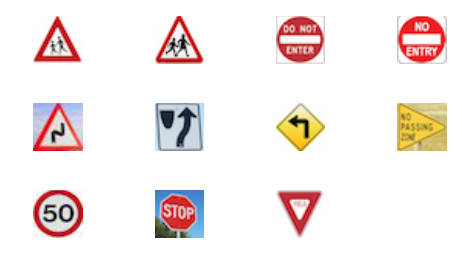

In [21]:
for i in range(np.shape(my_pic)[0]):
    plt.subplot(4,4, i+1)
    plt.axis('off')
    plt.subplots_adjust(hspace = .8)
    plt.imshow(my_pic[i])


In [22]:
# shape of the pic
print(np.shape(my_pic)[1:])

(32, 32, 3)


In [23]:
# converting pic in numpy array
my_pic = np.asarray(my_pic)

In [24]:
# Normalize all images
my_pic = my_pic.astype('float32')
for num in range(len(my_pic)):
    for x in xrange(0,32):
        for y in xrange(0,32):
            [r,g,b] = my_pic[num][x,y]
            r = (r-128)/128.0
            g = (g-128)/128.0
            b = (b-128)/128.0
            my_pic[num][x,y] = [r,g,b]

In [25]:
print("number of images: {}" .format(len(my_pic)))
print("shape of the images: {}" .format(np.shape(my_pic)[1:]))

number of images: 11
shape of the images: (32, 32, 3)


#### Question 6

Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook.

#### Answer 6

half of the images are taken from actual picture taken and then cropped and resized to 32x32, they might cause some error. While the other half are computer generated images like speed limit of 50, 70 etc, so they should be easily classified.

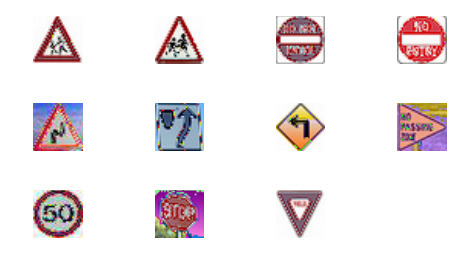

In [26]:
for i in range(np.shape(my_pic)[0]):
    plt.subplot(4,4, i+1)
    plt.axis('off')
    plt.subplots_adjust(hspace = .8)
    plt.imshow(my_pic[i])


In [27]:
y_new = [28,28,17,17,21,38,34,9,2,14,13]

In [28]:
#my_pic = np.reshape(my_pic, (np.shape(my_pic)[0],32,32,3))
my_pic.dtype

dtype('float32')

In [29]:
with tf.Session() as sess:    
    #sess.run(tf.initialize_all_variables())
    #saver = tf.train.import_meta_graph('project2_.meta')
    saver.restore(sess, 'project2_')
    #new_saver = tf.train.import_meta_graph('project2_.meta')
    #new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    out = sess.run(logits, feed_dict={x_: my_pic, keep_prob: 1.0})
    #newpics_accuracy = evaluate(my_pic, y_new)
    #print("Test Accuracy = {:.3f}".format(newpics_accuracy))

In [30]:
# Classification
y_outputlabels = []
for num in range(len(out)):
    y_outputlabels.append(np.argmax(out[num]))

#### Comparing the predicted and true labels

In [31]:
print("classfied labels: ", y_outputlabels)
print("true labels: ", y_new)

('classfied labels: ', [28, 28, 17, 17, 28, 32, 12, 25, 2, 14, 13])
('true labels: ', [28, 28, 17, 17, 21, 38, 34, 9, 2, 14, 13])


In [37]:
# Accuracy:
acc = 7./11
acc

0.6363636363636364

#### Question 7
Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate.

**NOTE:** You could check the accuracy manually by using signnames.csv (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in signnames.csv and see if it matches the sign from the image.

#### Answer 7:

My model was able to predict **63.63%** of all the test images. **The resolution of the images used in the test data was the main factor due to this error.** The model is good in predicting images using the shape, color and size of the sign, along with differnt shape object or text inside the sign.

But, it is still weak in predicting the sign when there are multiple text or images inside the sign. Therefore the middle 4 images are predicted incorrectly

**If we analyze the predict sign, we can observe, that the model predict 30km/hr speed sign instead of 50km/hr speed sign, it predicted "priroity pass" sign instead of "no passing" beacuse the shape and color of the sign is what the classification was mainly based on.**

**Also, using other preprocessing techniques, converting to gray scale and then than normalization or increasing the size of the data, by rotating or translation the images would have helped increase accuracy**

## Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [33]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

# define functions(unused)
#softmax_logits = tf.nn.softmax(logits)
#top_k = tf.nn.top_k(softmax_logits, k=3)

with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer())
    #new_saver = tf.train.import_meta_graph('traffic_signs.ckpt.meta')
    #new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    saver.restore(sess, 'project2_')
    
    my_softmax_logits = sess.run(tf.nn.softmax(logits), feed_dict={x_: my_pic, keep_prob: 1.0})
    out_top_k = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=3), feed_dict={x_: my_pic, keep_prob: 1.0})

### Print out the Top 3 Choices for each image

In [34]:
print(out_top_k)

TopKV2(values=array([[  1.00000000e+00,   5.96281546e-20,   3.54413218e-22],
       [  1.00000000e+00,   5.12348075e-09,   6.93859981e-14],
       [  9.99999881e-01,   8.13361964e-08,   1.90395033e-14],
       [  9.99999881e-01,   8.51819024e-08,   6.14155374e-13],
       [  1.00000000e+00,   2.73837071e-21,   4.06796991e-24],
       [  9.56478238e-01,   4.30828109e-02,   1.42302961e-04],
       [  9.99999881e-01,   1.32694339e-07,   4.17105822e-10],
       [  6.88384235e-01,   2.41936252e-01,   3.08765229e-02],
       [  1.00000000e+00,   4.35439022e-21,   1.64552009e-26],
       [  1.00000000e+00,   6.67388411e-28,   6.88530864e-30],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00]], dtype=float32), indices=array([[28, 30, 24],
       [28, 18, 26],
       [17, 22, 13],
       [17, 13, 22],
       [28, 30, 11],
       [32, 26, 12],
       [12, 14, 26],
       [25, 12, 13],
       [ 2,  1, 39],
       [14, 25, 17],
       [13,  0,  1]], dtype=int32))


### Checking how certain the model is in its predictions

In [35]:
# As the images were normalized for better view, reading the images once more
input_pic = []
for pic in glob.glob("./demo examples/*.jpg"):
    img = mpimg.imread(pic)
    input_pic.append(img)

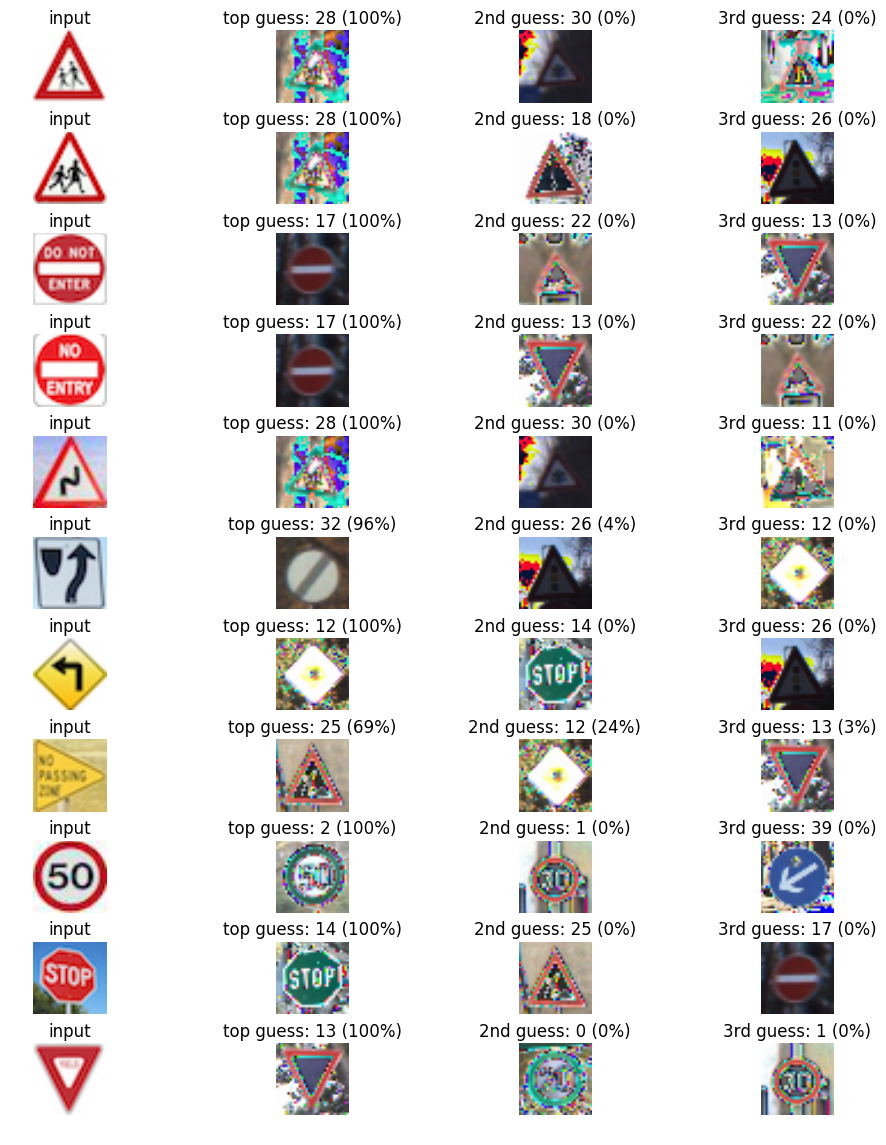

In [36]:
fig, axs = plt.subplots(len(input_pic),4, figsize=(12, 14))
fig.subplots_adjust(hspace = .4, wspace=.2)
axs = axs.ravel()

for i, image in enumerate(input_pic):
    axs[4*i].axis('off')
    axs[4*i].imshow(image)
    axs[4*i].set_title('input')
    guess1 = out_top_k[1][i][0]
    index1 = np.argwhere(y_validation == guess1)[0]
    axs[4*i+1].axis('off')
    axs[4*i+1].imshow(X_validation[index1].squeeze(), cmap='gray')
    axs[4*i+1].set_title('top guess: {} ({:.0f}%)'.format(guess1, 100*out_top_k[0][i][0]))
    guess2 = out_top_k[1][i][1]
    index2 = np.argwhere(y_validation == guess2)[0]
    axs[4*i+2].axis('off')
    axs[4*i+2].imshow(X_validation[index2].squeeze(), cmap='gray')
    axs[4*i+2].set_title('2nd guess: {} ({:.0f}%)'.format(guess2, 100*out_top_k[0][i][1]))
    guess3 = out_top_k[1][i][2]
    index3 = np.argwhere(y_validation == guess3)[0]
    axs[4*i+3].axis('off')
    axs[4*i+3].imshow(X_validation[index3].squeeze(), cmap='gray')
    axs[4*i+3].set_title('3rd guess: {} ({:.0f}%)'.format(guess3, 100*out_top_k[0][i][2]))